In [83]:
import numpy as np
import pandas as pd
import graphviz
from ipywidgets import interact
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import load_iris, make_moons
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBRegressor

# 1. Decision Trees

In [7]:
iris = load_iris()
data = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                    columns=iris['feature_names'] + ['target'])
data.drop(columns=['sepal length (cm)', 'sepal width (cm)'], inplace=True)
data

,petal length (cm),petal width (cm),target
0,1.4,0.2,0.0
1,1.4,0.2,0.0
2,1.3,0.2,0.0
3,1.5,0.2,0.0
4,1.4,0.2,0.0
...,...,...,...
145,5.2,2.3,2.0
146,5.0,1.9,2.0
147,5.2,2.0,2.0
148,5.4,2.3,2.0


In [30]:
X = data.drop(columns=['target']).values
y = data.target

In [32]:
y.value_counts()

target
0.0    50
1.0    50
2.0    50
Name: count, dtype: int64

In [33]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=2)
tree_clf.fit(X,y)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,2
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
# Export model graph
export_graphviz(tree_clf, out_file="iris_tree.dot",
                feature_names=data.drop(columns=['target']).columns,
                class_names=['0','1','2'],
                rounded=True, filled=True)

# Import model graph
with open("iris_tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

## Predicting

In [34]:
# Let's predict the class of a new flower
print(tree_clf.predict([[4, 1]]))

[1.]


In [35]:
# Predict proba
print(tree_clf.predict_proba([[4, 1]]))

[[0.         0.90740741 0.09259259]]


In [36]:
print(y)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
145    2.0
146    2.0
147    2.0
148    2.0
149    2.0
Name: target, Length: 150, dtype: float64


<Axes: >

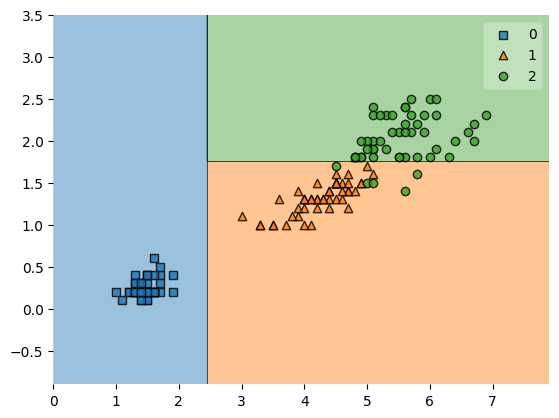

In [41]:
# Hand-made function to plot all predictions
plot_decision_regions(X, iris.target, clf=tree_clf)

## Controlling Overfitting

Decision trees must be tuned!
- Default parameters will almost certainly overfit
    - Control split with *min_samples_split*
    - Control leaves with *min_samples_leaf*
    - Control tree depth with *max_depth*

## Variance Illustrated

In [43]:
data = pd.read_csv("../data/ensemble/flats.csv")
data.head()

,price,bedrooms,surface,floors
0,274.0,3,1830,2.0
1,500.0,4,2120,1.0
2,320.0,3,1260,1.0
3,445.5,3,1880,1.0
4,637.5,3,1680,1.0


In [44]:
X = data[['bedrooms','surface','floors']]
y = data['price']

In [47]:
def plot_histogram_cv_results(cv_results):
    # Calculating the std and the mean
    std = cv_results['test_score'].std()
    mean = cv_results['test_score'].mean()

    # Getting the number of folds
    n_cv = len(cv_results['test_score'])

    # Building plot
    plt.hist(cv_results['test_score'], bins=n_cv)

    # Creating red lines
    plt.vlines(mean, 0, 3, color='red', label=f'mean = {mean:.2f}')
    plt.hlines(
        3, mean - 1/2 * std, mean + 1/2 * std,
        color='red', label=f'std = {std:.2f}', ls='dotted'
    )

    # Setting the title
    plt.title('Histogram of R2 Scores During Cross-Validation')

    # Setting the labels and xlim
    plt.xlim((-1, 1))

    plt.xlabel('r2')
    plt.ylabel('number of folds')

    # Showing the legend
    plt.legend(loc='upper left')

    plt.show()

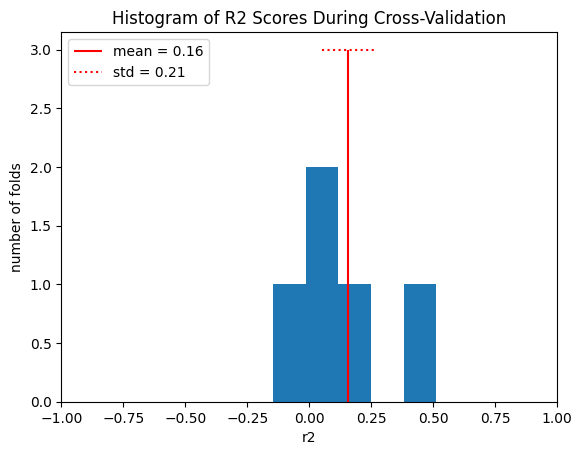

In [49]:
tree = DecisionTreeRegressor()

cv_results = cross_validate(tree, X, y, scoring = "r2", cv=5)

# Custom method
plot_histogram_cv_results(cv_results)

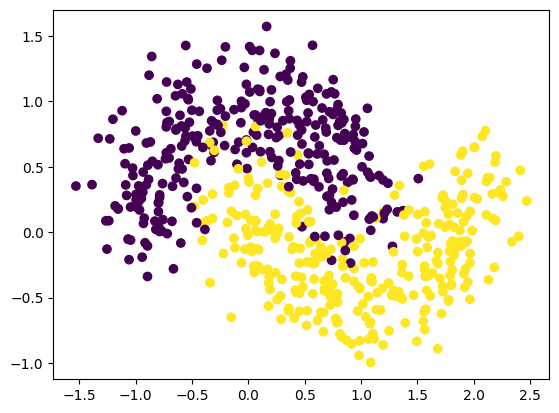

In [54]:
n=600
X_moon, y_moon = make_moons(n_samples=n, noise=0.25, random_state=0)

plt.scatter(X_moon[:,0], X_moon[:,1], c=y_moon)
plt.show()

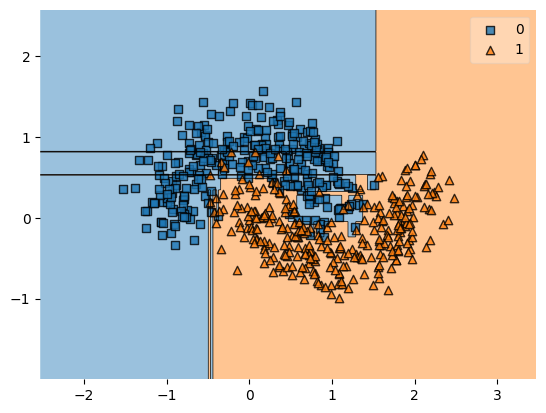

In [59]:
# @interact(max_depth=10)
def plot_classifier(max_depth):
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_moon, y_moon)
    plot_decision_regions(X_moon, y_moon, clf=clf)

plot_classifier(max_depth=10)

# 2. Bagging (i.e Bootstrap Aggregating)

## Random Forests = Bagged Trees

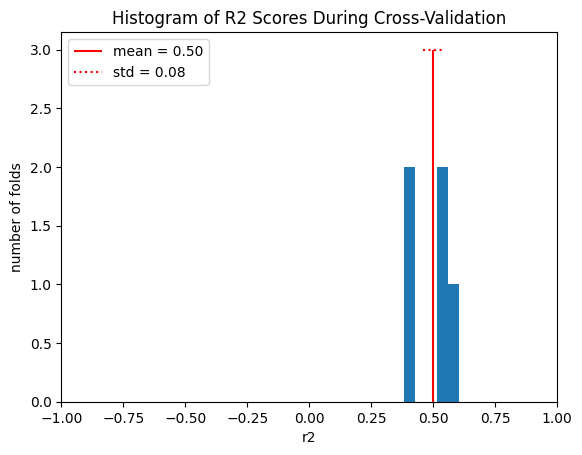

In [61]:
forest = RandomForestRegressor(n_estimators=100)

cv_results = cross_validate(forest, X, y, scoring = "r2", cv=5)

plot_histogram_cv_results(cv_results)

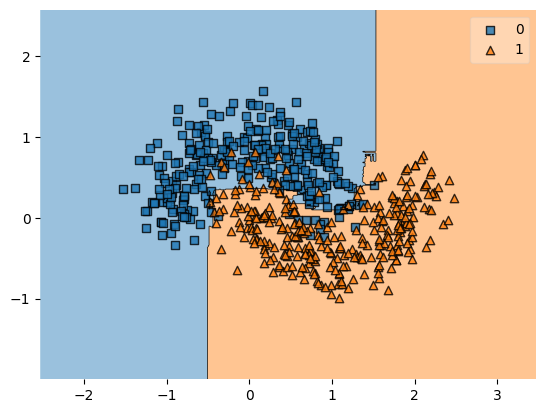

In [63]:
# @interact(max_depth=5)
def plot_classifier(max_depth):
    cls = RandomForestClassifier(max_depth=max_depth)
    cls.fit(X_moon, y_moon)
    plot_decision_regions(X_moon, y_moon, clf=cls)

plot_classifier(max_depth=5)

## Bagging any Algorithm (not just Trees)

<Axes: >

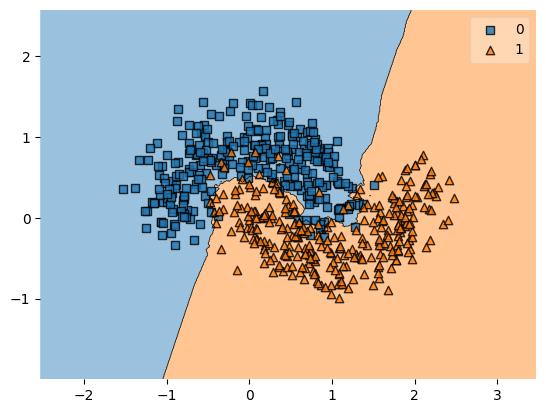

In [65]:
weak_learner = KNeighborsClassifier(n_neighbors=3)
bagged_model = BaggingClassifier(weak_learner, n_estimators=40)

bagged_model.fit(X_moon, y_moon)
plot_decision_regions(X_moon, y_moon, clf=bagged_model)

In [67]:
# Out-of-Bag Samples
linear_model = LinearRegression()

bagged_model = BaggingRegressor(linear_model, n_estimators=50, oob_score=True)

bagged_model.fit(X, y).oob_score_

0.5046226884123136

# 3. Boosting

## 3.1 AdaBoost (Adaptative Boosting)

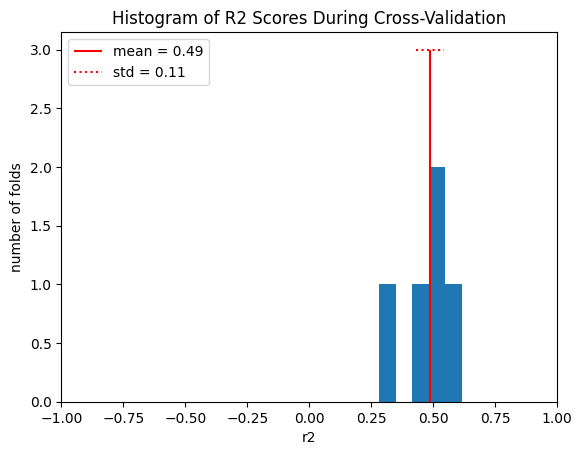

In [69]:
adaboost = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=3),
    n_estimators=50
)

cv_results = cross_validate(adaboost, X, y, scoring = "r2", cv=5)
plot_histogram_cv_results(cv_results)

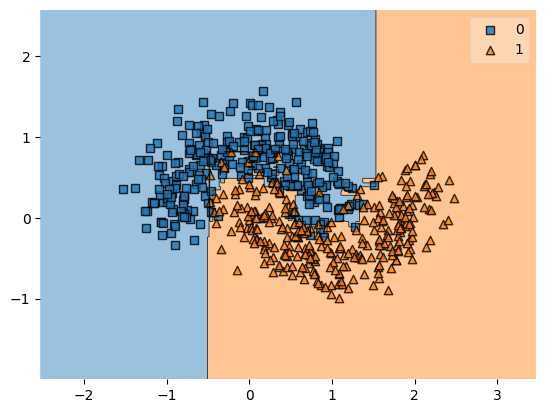

In [71]:
# @interact(n_estimators=[10, 30, 50,100], max_depth=3)
def plot_classifier(n_estimators, max_depth):
    model = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=max_depth),
        n_estimators=n_estimators
    )

    model.fit(X_moon, y_moon)
    plot_decision_regions(X_moon, y_moon, clf=model)

plot_classifier(n_estimators=50, max_depth=3)

## 3.2 Gradient Boosting

In [74]:
model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

## 3.3 XGBOOST

In [77]:
# Split data into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Use the same function above for the validation set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Then, we plug the data into the XGBRegressor
xgb_reg = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)

xgb_reg.fit(
    X_train,
    y_train,
    # evaluate loss at each iteration
    eval_set=[(X_train, y_train), (X_val, y_val)],
)

y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:339.51727	validation_1-rmse:332.92399
[1]	validation_0-rmse:318.24329	validation_1-rmse:318.01287
[2]	validation_0-rmse:299.13022	validation_1-rmse:305.53366
[3]	validation_0-rmse:281.95920	validation_1-rmse:295.52927
[4]	validation_0-rmse:266.37729	validation_1-rmse:287.38247
[5]	validation_0-rmse:252.34172	validation_1-rmse:280.82265
[6]	validation_0-rmse:239.63317	validation_1-rmse:275.80431
[7]	validation_0-rmse:228.09020	validation_1-rmse:271.66060
[8]	validation_0-rmse:217.82423	validation_1-rmse:268.76415
[9]	validation_0-rmse:208.46489	validation_1-rmse:266.48870
[10]	validation_0-rmse:199.92430	validation_1-rmse:264.74413
[11]	validation_0-rmse:192.07397	validation_1-rmse:262.95359
[12]	validation_0-rmse:185.31113	validation_1-rmse:262.21864
[13]	validation_0-rmse:179.05955	validation_1-rmse:261.58545
[14]	validation_0-rmse:173.29219	validation_1-rmse:260.87026
[15]	validation_0-rmse:168.34294	validation_1-rmse:259.80805
[16]	validation_0-rmse:163.96375	v

In [80]:
# Or integrate it into scikit-learn as a Pipeline
pipe_xgb = make_pipeline(xgb_reg)
cv_results = cross_validate(pipe_xgb, X, y, cv=10, scoring='r2')
cv_results['test_score'].mean()

np.float64(0.3221945910195873)

# 4. Stacking

## a) Simple aggregation

<Axes: >

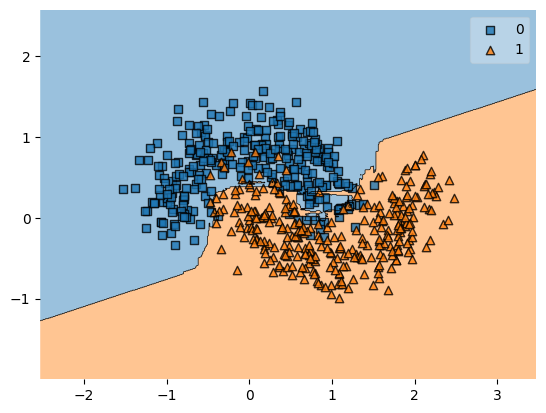

In [82]:
forest = RandomForestClassifier()
logreg = LogisticRegression()

ensemble = VotingClassifier(
    estimators = [("rf", forest),("lr", logreg)],
    voting = 'soft', # to use predict_proba of each classifier before voting
    weights = [1,1] # to equally weight forest and logreg in the vote
)

ensemble.fit(X_moon, y_moon)
plot_decision_regions(X_moon, y_moon, clf=ensemble)

## b) Multi-layer Stacking!

<Axes: >

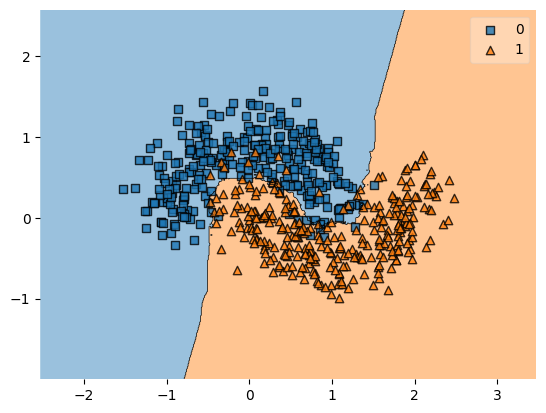

In [85]:
ensemble = StackingClassifier(
    estimators = [
        ("rf", RandomForestClassifier()),
        ("knn", KNeighborsClassifier(n_neighbors=10))
    ],
    final_estimator = LogisticRegression()
)

ensemble.fit(X_moon, y_moon)
plot_decision_regions(X_moon, y_moon, clf=ensemble)